In [1]:
using CSV
using DataFrames
using Plots
using FFTW

In [2]:
# MODEL, VISUALIZATION AND MANAGING FUNCTIONS FILES

push!(LOAD_PATH, "./src")
include("../src/DirUtils.jl")
include("../src/SDDESolarDynamo.jl")
include("../src/VisualizationTools.jl")

using .DirUtils
using .SDDESolarDynamo
using .VisualizationTools

In [3]:
# Load data
data = load_sunspots_data()

first(data, 5)

Row,year,open_magn_flux,open_magn_flux_err,ssa_open_magn_flux,sunspots_num,sunspots_err,ssa_sunspots
,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,971,7.86,1.65,5.29,120.5,39.4,62.2
2,972,4.94,1.06,5.36,47.9,17.4,65.3
3,973,3.08,1.24,5.45,2.7,20.2,68.6
4,974,1.9,1.39,5.56,-25.5,24.4,71.2
5,975,1.26,1.44,5.65,-49.7,23.3,73.0


In [100]:
# CHOICE OF THE DIRECTORY TO LOAD AND PLOT

# Current directory
initial_dir = pwd()

# Going into "synthetic_data_sim/synthetic$x" or "real_data_sim/real$x"
x = 11
switch_dir("real", x)
current_dir = pwd()

# NB: don't run this cell again! First go back to the initial directory!
# if pwd() != initial_dir
#     cd("./../../examples")
# end

Moved to: /mnt/c/Users/Utente/SDDESolarDynamo.jl/examples/real_data_sim/real11


"/mnt/c/Users/Utente/SDDESolarDynamo.jl/examples/real_data_sim/real11"

In [101]:
df_rho = CSV.read("rho.csv", DataFrame)
df_pop = CSV.read("pop.csv", DataFrame)

best_indices, best_particles = select_best_particles(df_rho, df_pop, k=10)
println("Best indices:", best_indices, "\n")
println("Best particles\n:", best_particles)

Best indices:[968, 228, 327, 329, 957, 803, 212, 507, 181, 372]

Best particles
:10×5 DataFrame
 Row │ N_value   T_value   tau_value  sigma_value  Bmax_value 
     │ Float64   Float64   Float64    Float64      Float64    
─────┼────────────────────────────────────────────────────────
   1 │  7.39336  3.21182    5.2622      0.299284      5.88976
   2 │ 13.0127   2.21213    0.651937    0.0328442     1.98171
   3 │  8.54077  0.820459   1.97092     0.156988      8.34098
   4 │  6.89407  3.37564    5.81711     0.0184667     6.05664
   5 │ 13.9798   7.37818    0.268819    0.192341      1.90098
   6 │ 13.7091   9.54251    2.23073     0.209977      1.95655
   7 │  6.87051  3.09819    5.51466     0.121942      5.91145
   8 │  7.81122  2.86046    3.80628     0.224443      5.49742
   9 │  7.1423   3.30424    3.81365     0.108714      4.83991
  10 │ 13.7944   3.83549    2.27763     0.0653041     2.55715


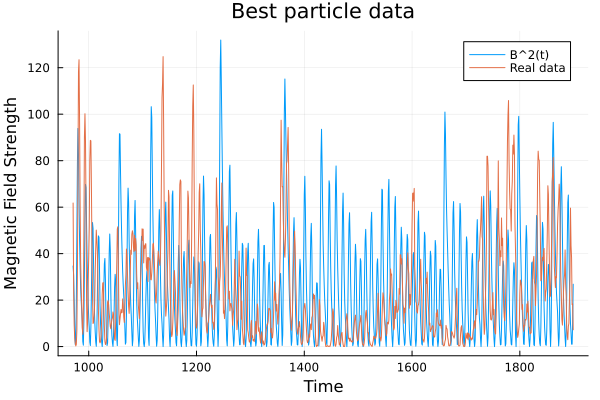

In [102]:
#par = [N, T, tau, sigma, B_max]
par = best_particles[1, :]

# Time
Tsim = [971, 1899]
dt = 0.1

# DATA SIMULATION

# Data simulation with the chosen parameter
sol = bfield(par, Tsim, dt)

# Important solution data that are necessary afterwards
t = sol.t
u = sol[1, :]
du = sol[2, :]

# Plot simulated data vs real data
Plots.plot(t, u.^2, label = "B^2(t)", xlabel = "Time", ylabel = "Magnetic Field Strength", 
               title = "Best particle data", linewidth = 1)

Plots.plot!(data.year, data.open_magn_flux.^2, label = "Real data")

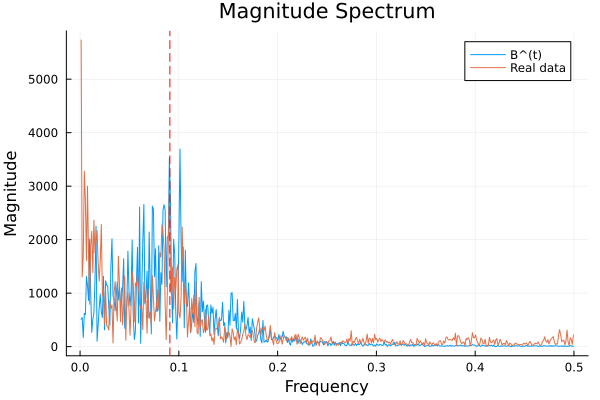

In [103]:
u = u.^2

Fs = 1 / (t[2] - t[1])
N = length(u)
freqs = fftfreq(N, Fs)

fourier_transform_sim = abs.(fft(u))

frequencies = freqs[(freqs .> 0) .& (freqs .<= 0.5)]
amplitudes = abs.(fourier_transform_sim[(freqs .> 0) .& (freqs .<= 0.5)])

Plots.plot(frequencies, amplitudes, xlabel="Frequency", ylabel="Magnitude", title="Magnitude Spectrum", label = "B^(t)")

t = data.year
u = data.open_magn_flux.^2

Fs = 1 / (t[2] - t[1])
N = length(u)
freqs = fftfreq(N, Fs)

fourier_transform_sim = abs.(fft(u))

frequencies = freqs[(freqs .> 0) .& (freqs .<= 0.5)]
amplitudes = abs.(fourier_transform_sim[(freqs .> 0) .& (freqs .<= 0.5)])
Plots.plot!(frequencies, amplitudes, label = "Real data")
vline!([1/11], line=:dash, color=:red, label=false)

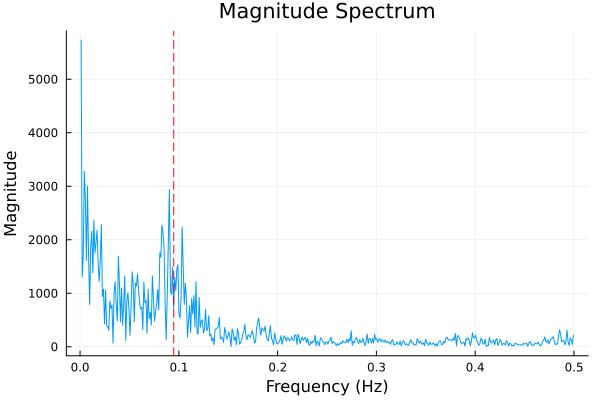

In [104]:
indices = [45]
plot_fourier_spectrum(t, u, indices; save=false)

Selected parameters (mode): [12.548363925774844, 4.030017130852998, 1.7935962377770658, 0.014935474591429757, 2.49569744228254]


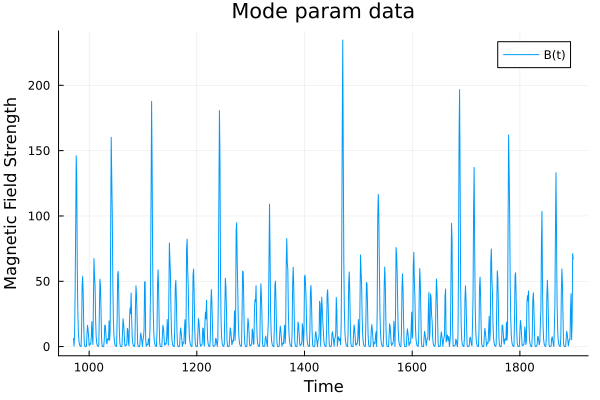

In [105]:
par, title_str = postprocessing_params(df_pop; strategy = :mode)

# Time
Tsim = [971, 1899]
dt = 0.1

# Simulate
sol = bfield(par, Tsim, dt)

# Extract solution
t = sol.t
u = sol[1, :]
du = sol[2, :]

# Plot
Plots.plot(t, u.^2, label = "B(t)", xlabel = "Time", ylabel = "Magnetic Field Strength",
           title = title_str, linewidth = 1)

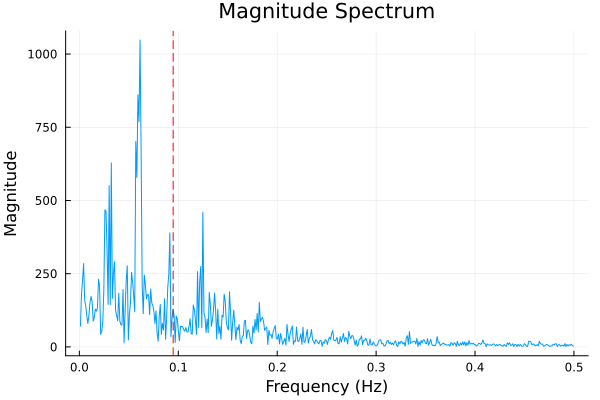

In [106]:
indices = [45]
plot_fourier_spectrum(t, u, indices; save=false)

Selected parameters (mean): [9.076871548412665, 3.691916463973741, 2.8568737204595243, 0.17463410427066497, 4.1523706821727036]


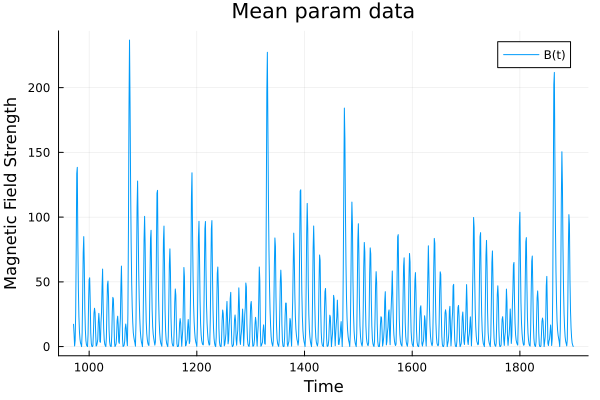

In [107]:
par, title_str = postprocessing_params(df_pop; strategy = :mean)

# Time
Tsim = [971, 1899]
dt = 0.1

# Simulate
sol = bfield(par, Tsim, dt)

# Extract solution
t = sol.t
u = sol[1, :]
du = sol[2, :]

# Plot
Plots.plot(t, u.^2, label = "B(t)", xlabel = "Time", ylabel = "Magnetic Field Strength",
           title = title_str, linewidth = 1)

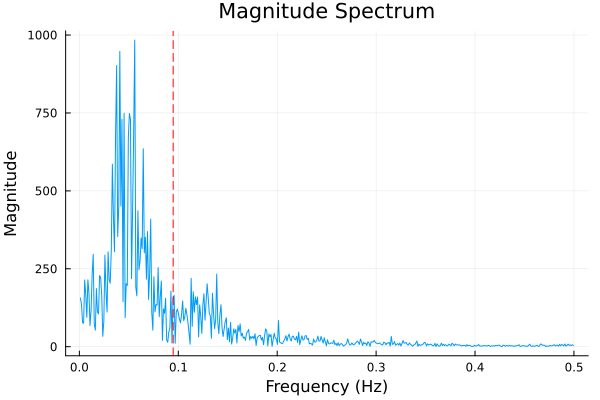

In [108]:
indices = [45]
plot_fourier_spectrum(t, u, indices; save=false)

Selected parameters (hybrid): [9.076871548412665, 2.952873689024652, 1.7935962377770658, 0.014935474591429757, 2.49569744228254]


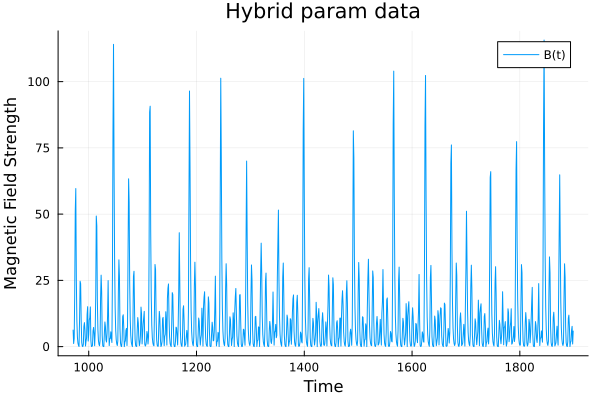

In [109]:
par, title_str = postprocessing_params(df_pop; strategy = :hybrid)

# Time
Tsim = [971, 1899]
dt = 0.1

# Simulate
sol = bfield(par, Tsim, dt)

# Extract solution
t = sol.t
u = sol[1, :]
du = sol[2, :]

# Plot
Plots.plot(t, u.^2, label = "B(t)", xlabel = "Time", ylabel = "Magnetic Field Strength",
           title = title_str, linewidth = 1)

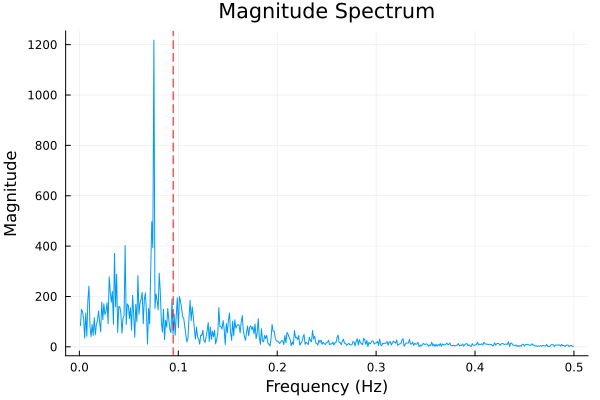

In [110]:
indices = [45]
plot_fourier_spectrum(t, u, indices; save=false)

In [111]:
# DIRECTORY MANAGING

# Go back to the initial directory if not already there
if pwd() != initial_dir
    cd("./../../../examples")
end

pwd()

"/mnt/c/Users/Utente/SDDESolarDynamo.jl/examples"